### Выбранные стили: y2k vs classic

### 1. Сбор небольшого датасета

По 20 изображений каждого стиля сохранениы в папке `data`:
- `/style_1` - y2k
- `/style_2` - classic

### 2. Мини-анализ стилей

   **y2k**: яркий, броский, насыщенный стиль, характерный для моды конца 90-х – начала 2000-х. Он отличается обилием блестящих материалов, металлизированных поверхностей, трикотажа с эластичностью, количеством открытых элементов, низкой посадкой брюк, обилием аксессуаров и насыщенной цветовой палитрой. Силуэты часто акцентирующие фигуру как засчет только приталенности, так и засчет сочетания ее с объемными вещам. Текстуры включают глянец, деним, кожу, меховые детали и принты. Обувь часто на высоком тонком каблуке или же акцентная спортивная. Характерен для тинейджеров.
   
   **classic**: характерны минимализм и структурированность, актуальность сквозь года. Этот стиль использует качественные натуральные материалы: шерсть, хлопок, кашемир, кожу. А также нейтральные и приглушённые цвета: чёрный, белый, бежевый, тёмно-синий. Силуэты чаще прямые, строгие и симметричные: пиджаки, брюки со стрелками, гладкие платья, пальто. Текстуры матовые, без лишнего декора, с чистыми линиями и чёткой посадкой. Количество аксессуаров минимально. Обувь зачастую из кожи на сдержанном каблуке. Может быть присущ людям всех возрастов.

   потенциальные признаки:
   - **цветовая гамма**: яркие/металлизированные оттенки vs нейтральные/базовые
   - **текстуры**: блеск и синтетика vs матовые натуральные материалы
   - **силуэты**: обтягивающие мини-силуэты vs строгие прямые линии
   - **детали**: y2k — декоративные элементы, обилие аксессуаров; classic — отсутствие декора, минимализм
   - **контраст на изображении**: y2k чаще имеет броские акценты и насыщенные участки
   - **обувь**: преобладают яркие, глянцевые и массивные модели vs нейтральная, минималистичная и строгая обувь
   - **возраст**: стиль y2k чаще встречается у подростков и молодых людей, classic встречается у всех

### 3. Обучение небольшой модели

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt

from glob import glob

import cv2

In [2]:
y2k_filepaths = glob('data/style_1/*.jpg')
classic_filepaths = glob('data/style_2/*.jpg')

In [3]:
# Mean/std из предобученных моделей ImageNet (RGB)
IMAGENET_MEAN = np.array([0.485, 0.456, 0.406])
IMAGENET_STD  = np.array([0.229, 0.224, 0.225])

In [4]:
def load_and_preprocess(path, size=(224, 224)):
    img = cv2.imread(path)

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    img = cv2.resize(img, size)

    img = img.astype(np.float32) / 255.0

    img = (img - IMAGENET_MEAN) / IMAGENET_STD

    return img

In [5]:
y2k_images = [load_and_preprocess(path) for path in y2k_filepaths]
classic_images = [load_and_preprocess(path) for path in classic_filepaths]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1179039301310043..2.6399999999999997].


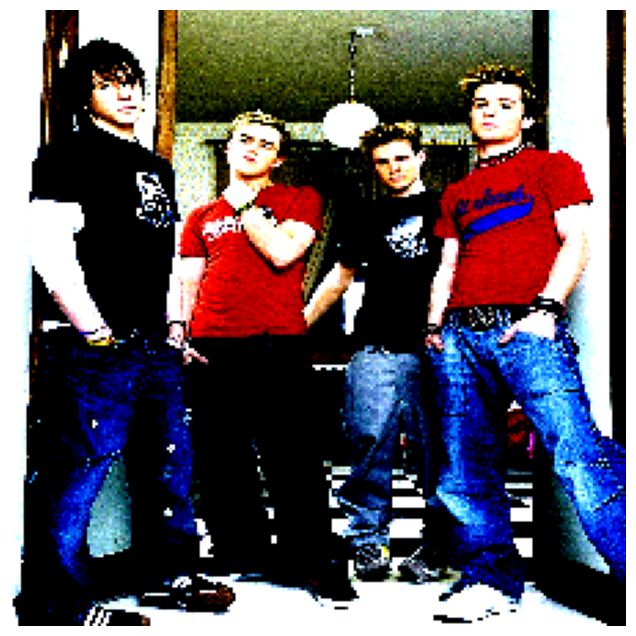

In [6]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(y2k_images[0])
ax.axis('off')
plt.show()

In [7]:
y2k_images[0].shape

(224, 224, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0670982618631215..2.6067415597165624].


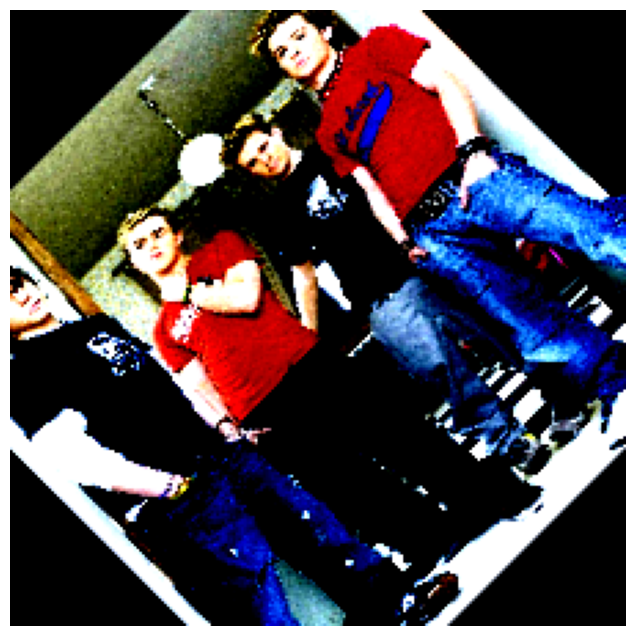

In [36]:
fig, ax = plt.subplots(figsize=(8, 8))
height, width = y2k_images[0].shape[:2]
 
center = (width // 2, height // 2)
 
rotation_matrix = cv2.getRotationMatrix2D(center, 45, 1.0)
 
rotated_image = cv2.warpAffine(y2k_images[0], rotation_matrix, (width, height))
 
ax.imshow(rotated_image)
ax.axis('off')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-27.898459543474015..31.29805623964451].


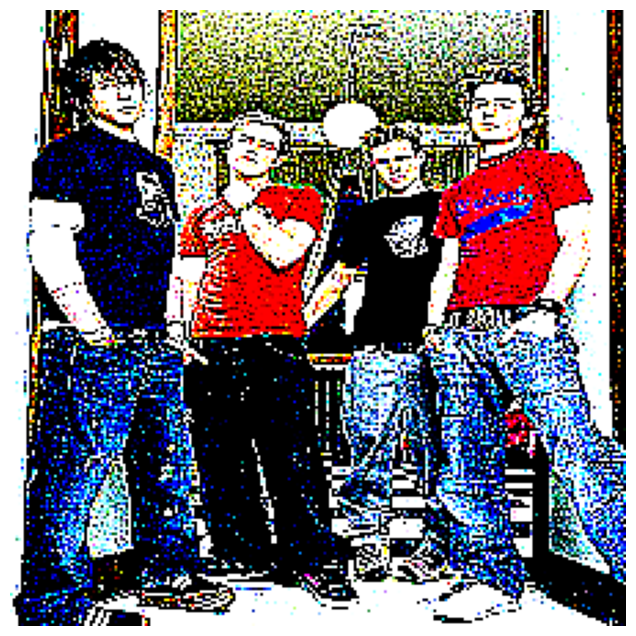

In [33]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cv2.filter2D(y2k_images[0], -1, np.array([[-1, -1, -1],
                    [-1, 10, -1],
                    [-1, -1, -1]])))
ax.axis('off')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1179039301310043..2.6399999999999997].


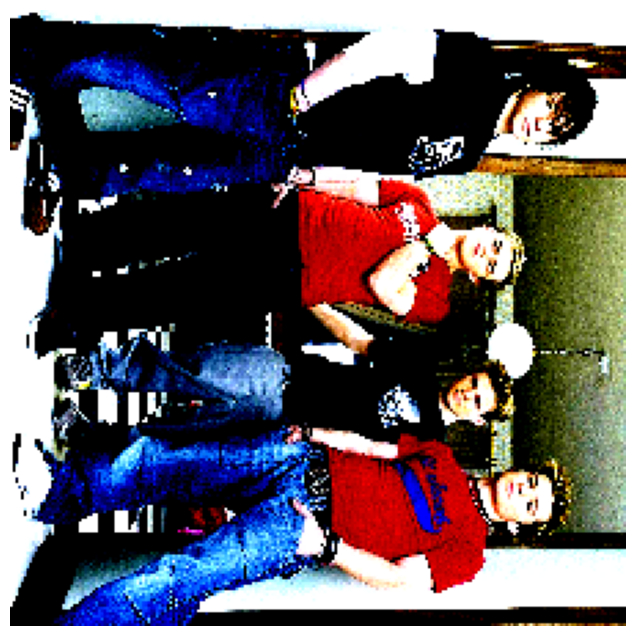

In [25]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cv2.rotate(y2k_images[0], cv2.ROTATE_90_CLOCKWISE))
ax.axis('off')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.964765794988604..1.250283200610307].


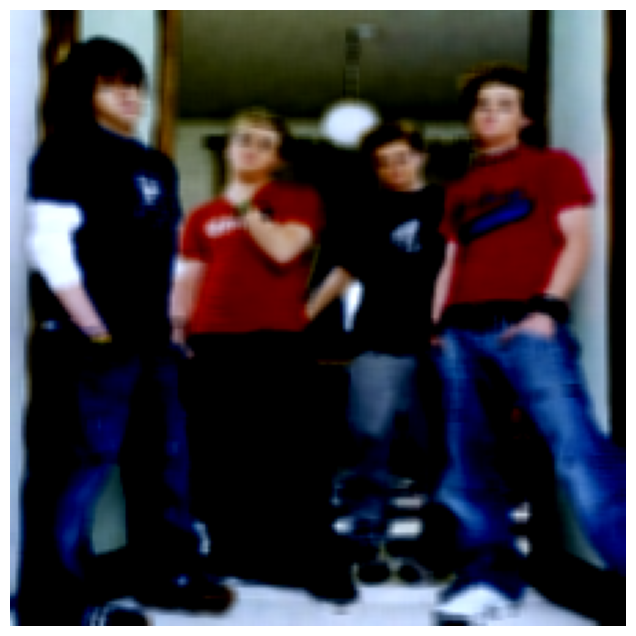

In [29]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cv2.filter2D(y2k_images[0], -1,  np.ones((5, 5), np.float32)/50))
ax.axis('off')
plt.show()

In [ ]:
def get_augementations(images):
    augenebatted_images = []
    augenebatted_images.append([cv2.filter2D(img,  -1,  np.ones((5, 5), np.float32)/50)) for img in images[:5]])
    augenebatted_images.append([cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE) for img in images[5:10]])
    augenebatted_images.append([cv2.filter2D(img,  -1, np.array([[-1, -1, -1],
                    [-1, 10, -1],
                    [-1, -1, -1]])) for img in images[10:15]])
    for img in images[15:]:
        height, width = img[0].shape[:2]
        center = (width // 2, height // 2)
     
        rotation_matrix = cv2.getRotationMatrix2D(center, 45, 1.0)
        augenebatted_images.append(cv2.warpAffine(img, rotation_matrix, (width, height))
        